In [2]:
# Attempt to solve QOSF monthly challenge march 2022 Task 1: https://github.com/qosf/monthly-challenges/blob/main/challenge-2022.03-mar/challenge-2022.03-mar.ipynb
import math
from collections import Counter

from qiskit import IBMQ, BasicAer
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.visualization import plot_histogram
import qiskit.quantum_info as qi
from qiskit.quantum_info import Statevector

from typing import List, Tuple
import numpy as np
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, execute
from qiskit_optimization import QuadraticProgram
from qiskit.circuit.quantumregister import QuantumRegister
from qiskit.circuit.classicalregister import ClassicalRegister
from qiskit.circuit.library import GroverOperator, ZGate
from qiskit.algorithms import AmplificationProblem

from qiskit_optimization.translators import from_docplex_mp
from qiskit.circuit.library.arithmetic.adders.draper_qft_adder import DraperQFTAdder
from qiskit.algorithms import Grover
from qiskit import Aer
from qiskit.compiler import transpile, assemble

# provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


3
[QuantumRegister(3, 'e0'), QuantumRegister(3, 'res'), QuantumRegister(1, 'addr0'), QuantumRegister(1, 'addr1'), QuantumRegister(1, 'addr2'), QuantumRegister(1, 'addr3'), QuantumRegister(1, 'addr4'), QuantumRegister(1, 'addr5')]
[QuantumRegister(3, 'e0'), QuantumRegister(3, 'res'), QuantumRegister(1, 'addr0'), QuantumRegister(1, 'addr1'), QuantumRegister(1, 'addr2'), QuantumRegister(1, 'addr3'), QuantumRegister(1, 'addr4'), QuantumRegister(1, 'addr5')]
[QuantumRegister(3, 'e0'), QuantumRegister(3, 'res'), QuantumRegister(1, 'addr0'), QuantumRegister(1, 'addr1'), QuantumRegister(1, 'addr2'), QuantumRegister(1, 'addr3'), QuantumRegister(1, 'addr4'), QuantumRegister(1, 'addr5')]
[QuantumRegister(3, 'e0'), QuantumRegister(3, 'res'), QuantumRegister(1, 'addr0'), QuantumRegister(1, 'addr1'), QuantumRegister(1, 'addr2'), QuantumRegister(1, 'addr3'), QuantumRegister(1, 'addr4'), QuantumRegister(1, 'addr5')]
[QuantumRegister(3, 'e0'), QuantumRegister(3, 'res'), QuantumRegister(1, 'addr0'), Qua

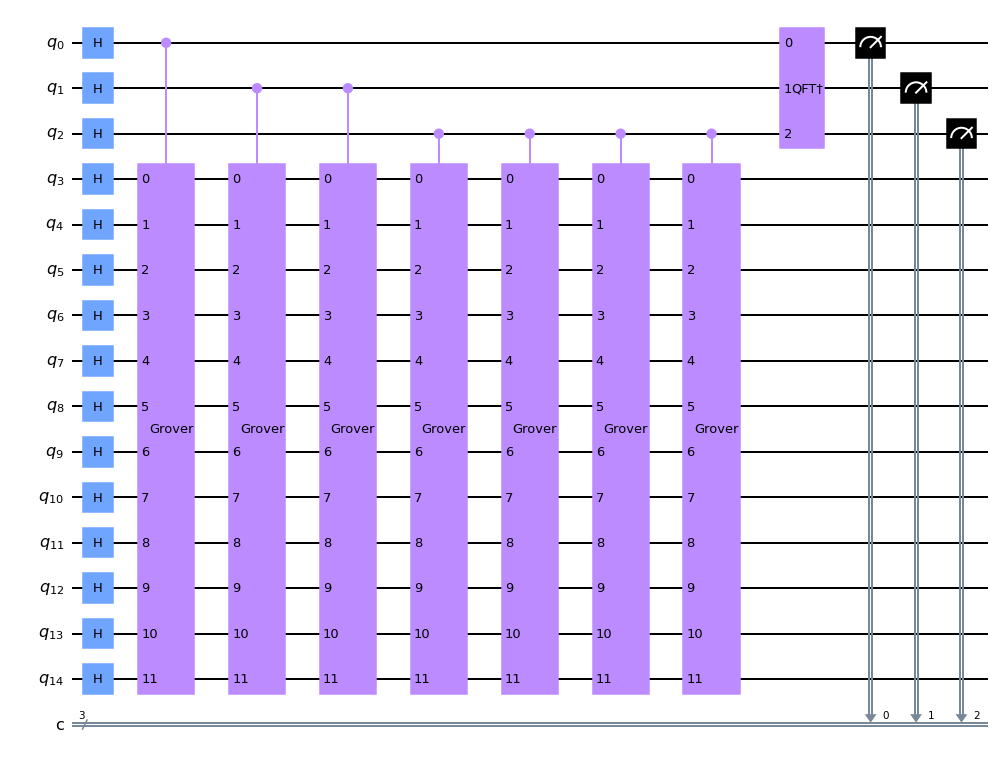

In [3]:
def get_registers(n, B):
    qregs=[] # quantum registers
    cregs=[] # classical registers
    for i in range(1):
        qregs.append(QuantumRegister(B, "e"+str(i)))
        cregs.append(ClassicalRegister(B, "ce"+str(i)))
    qregs.append(QuantumRegister(B, "res")) # result qubit
    cregs.append(ClassicalRegister(B, "cr")) # result qubit
    for i in range(n):
        qregs.append(QuantumRegister(1, "addr"+str(i)))
        cregs.append(ClassicalRegister(1, "caddr"+str(i)))
        
    return qregs, cregs

def get_registers_counting(n, B, s, t):
    qregs=[] # quantum registers
    cregs=[] # classical registers
    for i in range(1):
        qregs.append(QuantumRegister(B, "e"+str(i)))
    qregs.append(QuantumRegister(B, "res")) # result qubit
    for i in range(n):
        qregs.append(QuantumRegister(1, "addr"+str(i)))
    
        
    return qregs, cregs


def apply_h_on_address(c, n, qregs, B):
    for reg in qregs:
        if 'addr' in reg.name:
            c.h(reg)
        # c.h(qregs[B+1+i])
        

def set_values(c, arr, B, n, qregs):
    for i in range(len(arr)):
        val = arr[i]
        bin_val = bin(val)[2:]
        # do some padding
        bin_val = "0"*(B-len(bin_val))+bin_val
        ctrl = B*(n+1)+i
        for j, bin_digit in enumerate(bin_val):
            if bin_digit == "1":
                c.cx(ctrl,qregs[i][B-j-1])
                

def add_all(c, n, B, R, sign):
    for i in range(n):
        c = add(c, B, range(i*B, (i+1)*B), R, sign)
    return c


def add(c, B, q1, q2, sign):
    draper_circ = DraperQFTAdder(B)
    if sign == 1:
        c = c.compose(draper_circ, list(q1) + list(q2))
    elif sign == -1:
        c = c.compose(draper_circ.inverse(), list(q1) + list(q2))
    return c


def set_value_and_add_to_reg_and_unset_values(i, c, arr, B, n, R, qregs, sign):
    val = arr[i] 
    bin_val = bin(val)[2:]
    # do some padding
    bin_val = "0"*(B-len(bin_val))+bin_val
    print(qregs)
    # set values
    for idx, reg in enumerate(qregs):
        if reg.name == "addr"+str(i):
            ctrl = idx
            for j, bin_digit in enumerate(bin_val):
                if bin_digit == "1":
                    c.cx(qregs[idx][0], qregs[0][B-j-1])
    # add
    c = add(c, B, qregs[0], range(R[0]*B, R[0]*B+1*B), sign)
    # unset
    for idx, reg in enumerate(qregs):
        if reg.name == "addr"+str(i):
            ctrl = idx
            for j, bin_digit in enumerate(bin_val):
                if bin_digit == "1":
                    c.cx(qregs[idx][0], qregs[0][B-j-1])

    return c


def build_oracle(n, B, R, target_sum, qregs, as_gate=False):
    oracle = QuantumCircuit(*qregs)
    # part 2 set values, add to reg, unset_values
    for i in range(n):
        oracle = set_value_and_add_to_reg_and_unset_values(i, oracle, arr, B, n, R, qregs, 1)
        if not as_gate:
            oracle.barrier()
    # # part 3 oracle check
    t_bin = bin(target_sum)[2:]
    t_bin = "0"*(B-len(t_bin))+t_bin
    print(target_sum)
    for i, bin_digit in enumerate(t_bin):
        print(i, bin_digit, "i")
        if str(bin_digit) == "0":
            print(1*B+B-i-1)
            print("here")
            oracle.x(1*B+B-i-1)
    oracle.append(ZGate().control(B-1), range(1*B,1*B+B))
    for i, bin_digit in enumerate(t_bin):
        if bin_digit == "0":
            oracle.x(1*B+B-i-1)
    # # part 5 set value, subtract from register, unsetvalue
    for i in range(n):
        oracle = set_value_and_add_to_reg_and_unset_values(i, oracle, arr, B, n, R, qregs, -1)
        if not as_gate:
            oracle.barrier()
        
    return oracle


def build_diffuser(n):
    diffuser = QuantumCircuit(n) # just the address qubits
    for j in range(n):
        diffuser.h(j)
        diffuser.x(j)
    LAST = n-1
    diffuser.h(LAST)
    # ccnot (multi control Tofolli gate)
    diffuser.mct(list(range(0, n-1)), LAST)
    diffuser.h(LAST)
    for j in range(n):
        diffuser.x(j)
        diffuser.h(j)
        
    return diffuser


def grovers_iteration(c, oracle, diffuser, B, n, as_gate=False):
    c = c.compose(oracle)
    if not as_gate:
        c.barrier()
    c = c.compose(diffuser, range(2*B, 2*B+n))
    if not as_gate:
        c.barrier()
    return c


def grovers_search(c, n, B, R, target_sum, grover_iterations, qregs, as_gate=False):
    # GET THE ORACLE
    oracle = build_oracle(n, B, R, target_sum, qregs, as_gate)

    # Now build the Diffuser
    diffuser = build_diffuser(n)
    
    for i in range(grover_iterations):
        c = grovers_iteration(c, oracle, diffuser, B, n, as_gate)
        
    return c


def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit


def counting(t, s, arr, B, target_sum, grover_iterations):
    def grovers_iter(c, n, B, R, target_sum, grover_iterations, qregs, as_gate):
        # GET THE ORACLE
        oracle = build_oracle(n, B, R, target_sum, qregs, as_gate)

        # Now build the Diffuser
        diffuser = build_diffuser(n)

        # For the counting algorithm we just need
        # a single iteration to differentiate between the phases
        # of answers and non-answers.
        c = grovers_iteration(c, oracle, diffuser, B, n, as_gate)

        return c
    
    
    n = len(arr)
    addr=[0]*n
    qregs, cregs = get_registers(n, B)
    
    R = []
    for idx, reg in enumerate(qregs):
        if "res" in reg.name:
            R.append(idx)
        
    c = QuantumCircuit(*qregs)
    # apply_h_on_address(c, n, qregs, B)
    # return grovers_iter(c, n, B, R, target_sum, grover_iterations, qregs, True)
    
    grovers_iter = grovers_iter(c, n, B, R, target_sum, grover_iterations, qregs, True).to_gate()
    grovers_iter.label = "Grover"
    controlled_grovers = grovers_iter.control()

    qft_dagger = qft(t).to_gate().inverse()
    qft_dagger.label = "QFT†"
    
    # Create QuantumCircuit
    qc = QuantumCircuit(s+t, t) # Circuit with n+t qubits and t classical bits

    # Initialize all qubits to |+>
    for qubit in range(s+t):
        qc.h(qubit)

    # Begin controlled Grover iterations
    iterations = 1
    for qubit in range(t):
        for i in range(iterations):
            target_qargs = [qubit] + [*range(t, s+t)]
            print(target_qargs)
            qc.append(controlled_grovers, target_qargs)
        iterations *= 2

    # Do inverse QFT on counting qubits
    qc.append(qft_dagger, range(t))

    # Measure counting qubits
    qc.measure(range(t), range(t))
    
    return qc


def get_circ(arr, B, target_sum, grover_iterations):
    n = len(arr)
    addr=[0]*n
    qregs, cregs = get_registers(n, B)
    
    R = []
    for idx, reg in enumerate(qregs):
        if "res" in reg.name:
            R.append(idx)
        
    c = QuantumCircuit(*qregs, *cregs)
    apply_h_on_address(c, n, qregs, B)
    c.barrier()
    # GROVERS SHIT
    c = grovers_search(c, n, B, R, target_sum, grover_iterations, qregs)
    # c.barrier()
    c.measure(range(0, 2*B+n), range(0, 2*B+n))
    return c


arr = [1, 3, 6, 4, 2, 6]
# 11001 -> 10011
# 00100 -> 00100
# 00011 -> 11000
# 11110 -> 01111
# [('0 1 1 1 1 000 000', 208), ('1 0 0 1 1 000 000', 205), ('0 0 1 0 0 000 000', 190), ('1 1 0 0 0 000 000', 187), 
B = len(bin(max(arr))) - 2 # bit_length
t = 3   # no. of counting qubits
s = len(arr) + 2 * B   # no. of searching qubits
print(B)
k=3
# N=2**(2*4+3)
N=2**B
grover_iterations = int(math.sqrt(N/k)*math.pi/4)

#c = get_circ(arr, B, 6, grover_iterations)
c = counting(t, s, arr, B, 6, grover_iterations)
c.draw('mpl')

In [4]:
from itertools import combinations

one = [list(i) for i in combinations(arr, 1)]
two = [list(i) for i in combinations(arr, 2)]
three = [list(i) for i in combinations(arr, 3)]
four = [list(i) for i in combinations(arr, 4)]
five = [list(i) for i in combinations(arr, 5)]
six = [list(i) for i in combinations(arr, 6)]

one.extend(two)
one.extend(three)
one.extend(four)
one.extend(five)
one.extend(six)

counter = 0
for value in one:
    if sum(value) % 8 == 6:
        counter += 1
print(counter)

8


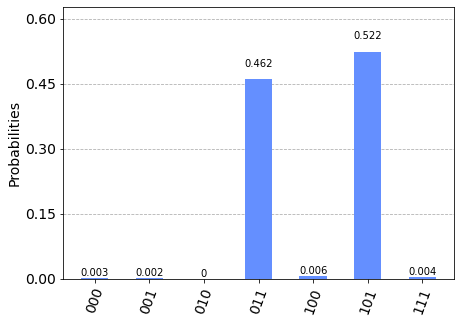

In [5]:
# Execute and see results
aer_sim = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(c, aer_sim)
qobj = assemble(transpiled_qc)
job = aer_sim.run(qobj)
hist = job.result().get_counts()
plot_histogram(hist)

In [9]:
measured_str = max(hist, key=hist.get)
measured_int = int(measured_str,2)
print(measured_str)
print(measured_int)

def calculate_M(measured_int, t, s):
    """For Processing Output of Quantum Counting"""
    # Calculate Theta
    theta = (measured_int/(2**t))*math.pi*2
    print("Theta = %.5f" % theta)
    # Calculate No. of Solutions
    N = 2**len(arr)
    print(N)
    M = N * (math.sin(theta/2)**2)
    print(M)
    print("No. of Solutions = %.1f" % (N-M))
    # Calculate Upper Error Bound
    m = t - 1 #Will be less than this (out of scope) 
    err = (math.sqrt(2*M*N) + N/(2**(m+1)))*(2**(-m))
    print("Error < %.2f" % err)
    
calculate_M(measured_int, t, s)

101
5
Theta = 3.92699
64
54.62741699796952
No. of Solutions = 9.4
Error < 22.91


[('0 1 1 1 1 000 000', 208), ('1 0 0 1 1 000 000', 205), ('0 0 1 0 0 000 000', 190), ('1 1 0 0 0 000 000', 187), ('0 1 1 0 1 000 000', 12), ('0 1 1 1 0 000 000', 11), ('1 0 0 0 1 000 000', 10), ('1 0 1 0 0 000 000', 10), ('0 0 1 1 0 000 000', 10), ('1 0 1 1 0 000 000', 10), ('1 1 0 1 0 000 000', 9), ('1 0 0 0 0 000 000', 9), ('0 0 1 0 1 000 000', 9), ('1 1 1 1 1 000 000', 8), ('0 0 1 1 1 000 000', 8), ('1 0 1 1 1 000 000', 8), ('0 0 0 1 1 000 000', 8), ('0 1 0 0 1 000 000', 8), ('0 0 0 1 0 000 000', 7), ('1 0 0 1 0 000 000', 7), ('0 0 0 0 1 000 000', 7), ('1 1 0 1 1 000 000', 7), ('1 1 0 0 1 000 000', 7), ('0 0 0 0 0 000 000', 7), ('1 1 1 0 0 000 000', 6), ('0 1 0 1 1 000 000', 6), ('1 1 1 0 1 000 000', 5), ('0 1 1 0 0 000 000', 5), ('1 0 1 0 1 000 000', 4), ('1 1 1 1 0 000 000', 4), ('0 1 0 0 0 000 000', 4), ('0 1 0 1 0 000 000', 4)]


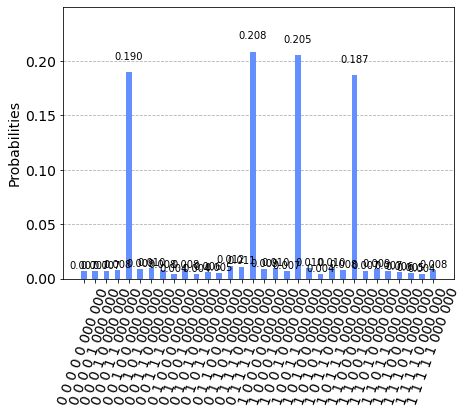

In [46]:
backend = BasicAer.get_backend('qasm_simulator')
shots = 1000
results = execute(c, backend=backend, shots=shots).result()
answer = results.get_counts()

print(Counter(answer).most_common())
# print(answer)
plot_histogram(answer)